### CNN

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "sugarcane RA",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 300 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterial Blight', 'Healthy', 'Red Rot']

In [5]:
len(dataset)

10

In [6]:
10*32

320

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 2 1 1 2 2 2 1 1 2 2 1 2 2 0 2 2 0 0 2 0 0 1 2 2 0 1 0 1 0 2]


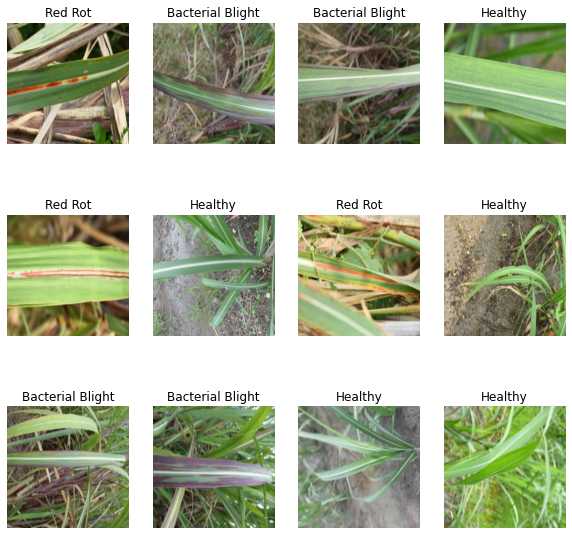

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

10

In [10]:
train_size = 0.8
len(dataset)*train_size

8.0

In [11]:
train_ds = dataset.take(8)
len(train_ds)

8

In [12]:
test_ds = dataset.skip(8)
len(test_ds)

2

In [13]:
val_size=0.1
len(dataset)*val_size

1.0

In [14]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [15]:
test_ds = test_ds.skip(1)
len(test_ds)

1

In [30]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [31]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [32]:
len(train_ds)

6

In [33]:
len(val_ds)

2

In [34]:
len(test_ds)

2

In [35]:
train_ds = train_ds.cache().shuffle(300).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(300).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(300).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
#Rescaling and resizing
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [37]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [38]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [42]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
6/6 [==============================] - 8s 1s/step - loss: 1.0973 - accuracy: 0.3646 - val_loss: 1.0839 - val_accuracy: 0.4062
Epoch 2/50
6/6 [==============================] - 6s 1s/step - loss: 1.0970 - accuracy: 0.3281 - val_loss: 1.0816 - val_accuracy: 0.3594
Epoch 3/50
6/6 [==============================] - 6s 1s/step - loss: 1.0840 - accuracy: 0.4115 - val_loss: 1.0744 - val_accuracy: 0.4219
Epoch 4/50
6/6 [==============================] - 6s 960ms/step - loss: 1.0587 - accuracy: 0.4375 - val_loss: 1.0258 - val_accuracy: 0.5156
Epoch 5/50
6/6 [==============================] - 6s 976ms/step - loss: 0.9496 - accuracy: 0.5573 - val_loss: 0.8748 - val_accuracy: 0.5781
Epoch 6/50
6/6 [==============================] - 6s 1s/step - loss: 0.8861 - accuracy: 0.5312 - val_loss: 1.1195 - val_accuracy: 0.4219
Epoch 7/50
6/6 [==============================] - 6s 996ms/step - loss: 0.9543 - accuracy: 0.4844 - val_loss: 0.8357 - val_accuracy: 0.6562
Epoch 8/50
6/6 [================

In [43]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 1s 223ms/step - loss: 0.5549 - accuracy: 0.7344


In [44]:
scores

[0.5548912286758423, 0.734375]

In [45]:
history

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 6}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
type(history.history['loss'])

list

In [49]:
len(history.history['loss'])

50

In [50]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.097256064414978,
 1.0969818830490112,
 1.083962082862854,
 1.0586751699447632,
 0.9495973587036133]

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

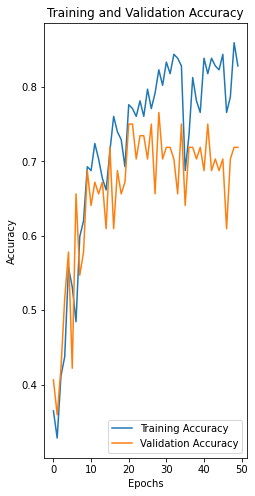

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


first image to predict
actual label: Healthy
1/1 [==============================] - 0s 414ms/step
predicted label: Healthy


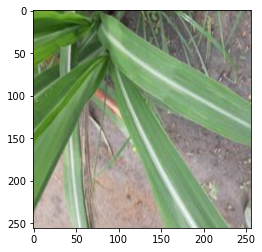

In [53]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 53ms/step


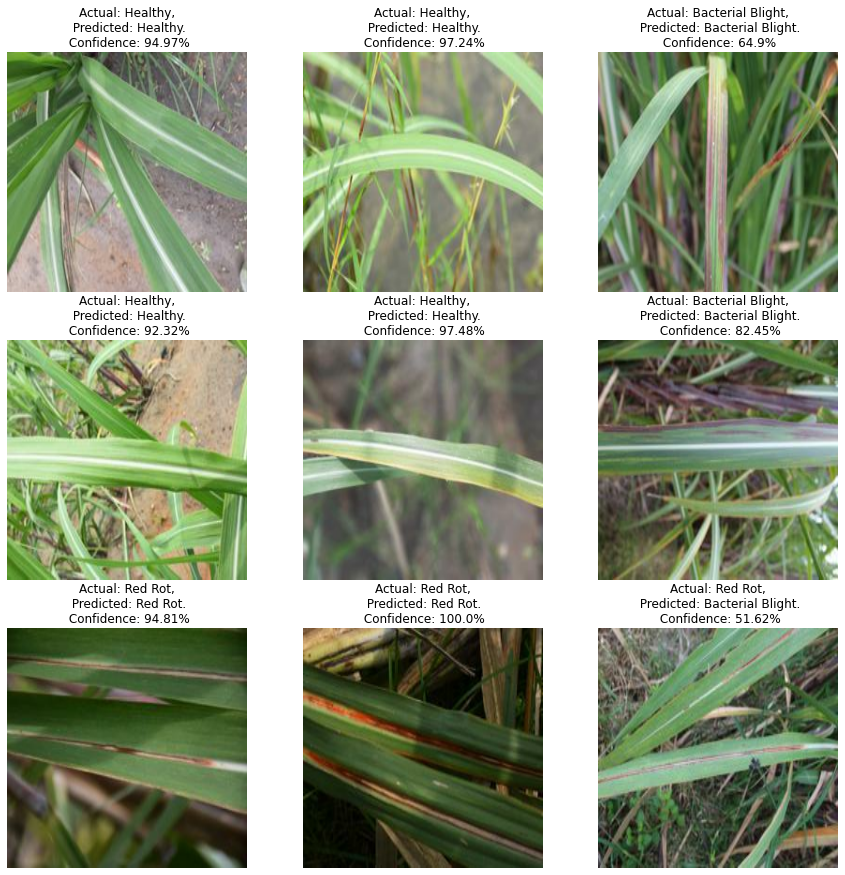

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [58]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [59]:
model.compile(
    optimizer='SGD',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [60]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
6/6 [==============================] - 7s 1s/step - loss: 4.2219 - accuracy: 0.3177 - val_loss: 1.0845 - val_accuracy: 0.4062
Epoch 2/50
6/6 [==============================] - 6s 990ms/step - loss: 1.1003 - accuracy: 0.3490 - val_loss: 1.0827 - val_accuracy: 0.4062
Epoch 3/50
6/6 [==============================] - 6s 945ms/step - loss: 1.0958 - accuracy: 0.3542 - val_loss: 1.0815 - val_accuracy: 0.4062
Epoch 4/50
6/6 [==============================] - 7s 1s/step - loss: 1.0933 - accuracy: 0.3542 - val_loss: 1.0802 - val_accuracy: 0.4062
Epoch 5/50
6/6 [==============================] - 8s 1s/step - loss: 1.0899 - accuracy: 0.3542 - val_loss: 1.0757 - val_accuracy: 0.4062
Epoch 6/50
6/6 [==============================] - 7s 1s/step - loss: 1.0912 - accuracy: 0.3542 - val_loss: 1.0710 - val_accuracy: 0.4062
Epoch 7/50
6/6 [==============================] - 6s 974ms/step - loss: 1.0859 - accuracy: 0.3490 - val_loss: 1.0703 - val_accuracy: 0.4062
Epoch 8/50
6/6 [================

In [61]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 0s 246ms/step - loss: 0.8737 - accuracy: 0.6250


In [62]:
scores

[0.8737474679946899, 0.625]

In [63]:
history

In [64]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 6}

In [65]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [66]:
type(history.history['loss'])

list

In [67]:
len(history.history['loss'])

50

In [68]:
history.history['loss'][:5] # show loss for first 5 epochs

[4.221884250640869,
 1.1003077030181885,
 1.0958105325698853,
 1.0933064222335815,
 1.089937686920166]

In [69]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

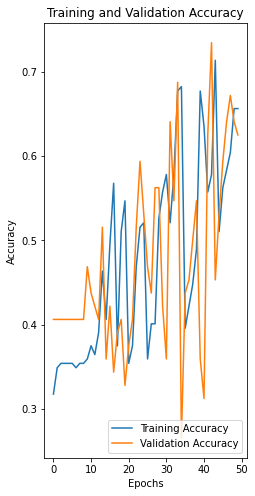

In [70]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


first image to predict
actual label: Healthy
1/1 [==============================] - 0s 347ms/step
predicted label: Bacterial Blight


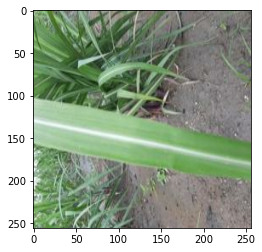

In [71]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [72]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 56ms/step


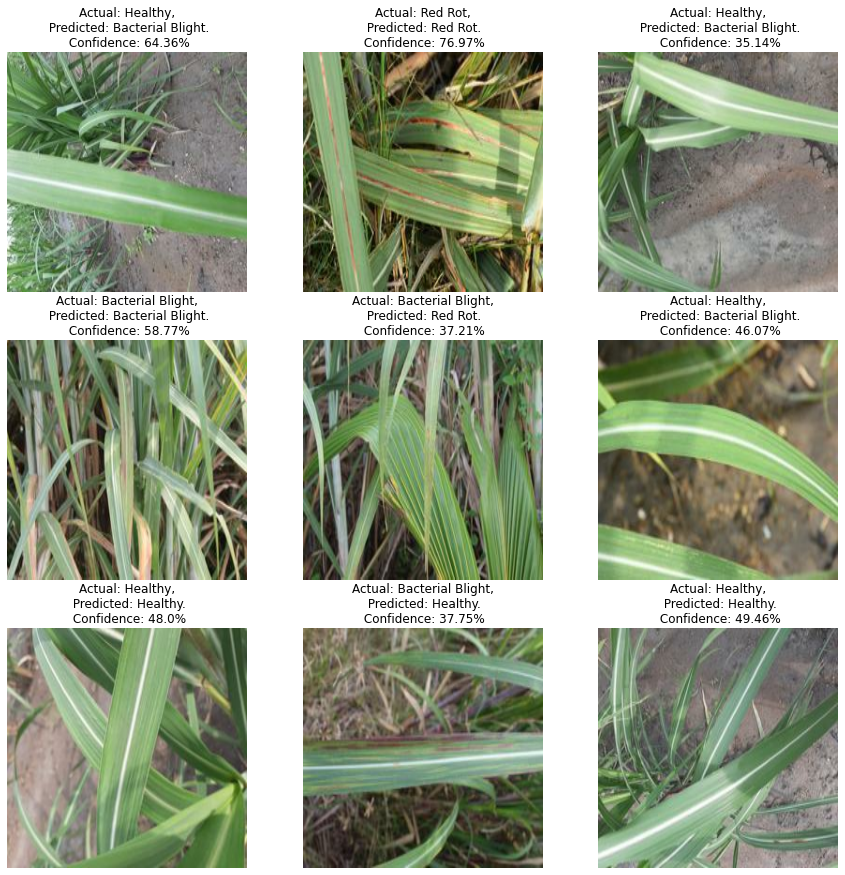

In [73]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [74]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [75]:
model.compile(
    optimizer='Adagrad',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [76]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
6/6 [==============================] - 8s 1s/step - loss: 0.8159 - accuracy: 0.6667 - val_loss: 0.8153 - val_accuracy: 0.6250
Epoch 2/50
6/6 [==============================] - 6s 968ms/step - loss: 0.7900 - accuracy: 0.6510 - val_loss: 0.7987 - val_accuracy: 0.6406
Epoch 3/50
6/6 [==============================] - 6s 975ms/step - loss: 0.7557 - accuracy: 0.6875 - val_loss: 0.7729 - val_accuracy: 0.6719
Epoch 4/50
6/6 [==============================] - 6s 1s/step - loss: 0.7626 - accuracy: 0.6823 - val_loss: 0.7544 - val_accuracy: 0.6719
Epoch 5/50
6/6 [==============================] - 6s 1s/step - loss: 0.7110 - accuracy: 0.7031 - val_loss: 0.7353 - val_accuracy: 0.6875
Epoch 6/50
6/6 [==============================] - 6s 985ms/step - loss: 0.6742 - accuracy: 0.7552 - val_loss: 0.7178 - val_accuracy: 0.7188
Epoch 7/50
6/6 [==============================] - 6s 964ms/step - loss: 0.6533 - accuracy: 0.7656 - val_loss: 0.7005 - val_accuracy: 0.7031
Epoch 8/50
6/6 [=============

In [77]:
scores = model.evaluate(test_ds)


2/2 [==============================] - 0s 217ms/step - loss: 0.7098 - accuracy: 0.6562


In [78]:
scores


[0.7097536325454712, 0.65625]

In [79]:
history


In [80]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 6}

In [81]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [82]:
type(history.history['loss'])


list

In [83]:
len(history.history['loss'])


50

In [84]:
history.history['loss'][:5] # show loss for first 5 epochs



[0.8159286975860596,
 0.7900215983390808,
 0.7557184100151062,
 0.7626263499259949,
 0.7110210061073303]

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']




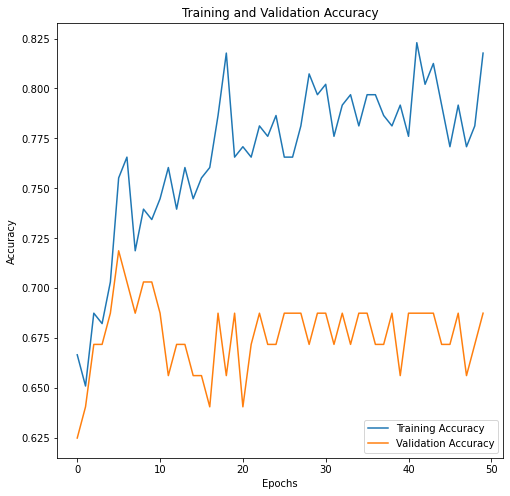

In [87]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()



first image to predict
actual label: Healthy
1/1 [==============================] - 0s 325ms/step
predicted label: Bacterial Blight


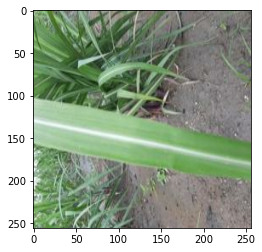

In [88]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])




In [89]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence




1/1 [==============================] - 0s 44ms/step


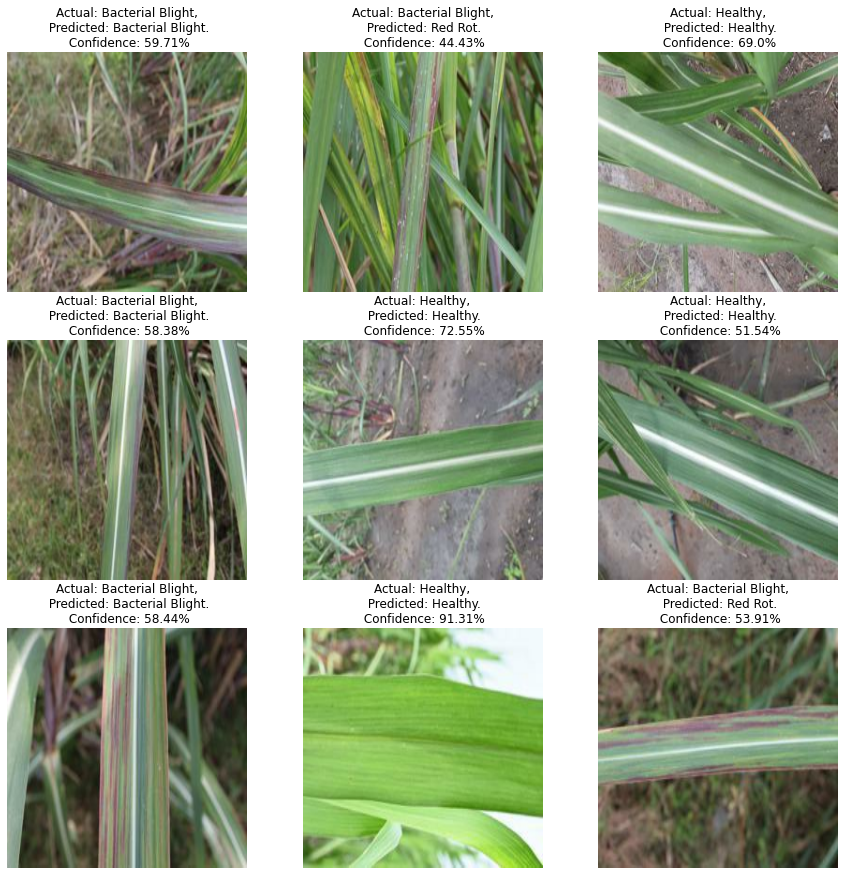

In [327]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")



<p><b>**************************************************************************************************************</b></p>

In [245]:
dataset_path = "C:/Users/meghn/Internship/Sugarcane/sugarcane RA"
dataset_path

'C:/Users/meghn/Internship/Sugarcane/sugarcane RA'

In [246]:
for filename in os.listdir(dataset_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Read in the image file
        img = Image.open(os.path.join(dataset_path, filename))

        # Perform some operations on the image, e.g. resize it
        img = img.resize((256, 256))

        # Do something with the processed image, e.g. save it to a new directory
        img.save(os.path.join("processed_images", filename))

In [247]:
from PIL import Image

# Open the image file
img = Image.open("C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Bacterial Blight/S_BLB (11).JPG")

# Get the size of the image
width, height = img.size

# Print the size of the image
print("Width:", width)
print("Height:", height)

Width: 256
Height: 170


### SVM

In [97]:

import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [108]:
Categories=['Bacterial Blight','Red Rot','Healthy']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir= "C:/Users/meghn/Internship/Sugarcane/sugarcane RA"
#path which contains all the categories of images
for i in Categories:
      
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(150,150,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)

loading... category : Bacterial Blight
loaded category:Bacterial Blight successfully
loading... category : Red Rot
loaded category:Red Rot successfully
loading... category : Healthy
loaded category:Healthy successfully


In [109]:
#dataframe
df=pd.DataFrame(flat_data) 
df['Target']=target
df.shape

(300, 67501)

In [110]:
#input data 
x=df.iloc[:,:-1] 
#output data
y=df.iloc[:,-1]

In [101]:
# Splitting the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,
                                               random_state=77,
                                               stratify=y)

In [102]:
# Defining the parameters grid for GridSearchCV
param_grid={'C':[0.1,1,10,100],
            'gamma':[0.0001,0.001,0.1,1],
            'kernel':['rbf','poly']}
  
# Creating a support vector classifier
svc=svm.SVC(probability=True)
  
# Creating a model using GridSearchCV with the parameters grid
model=GridSearchCV(svc,param_grid)

In [103]:
# Training the model using the training data
model.fit(x_train,y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [104]:
# Testing the model using the testing data
y_pred = model.predict(x_test)
  
# Calculating the accuracy of the model
accuracy = accuracy_score(y_pred, y_test)
  
# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")

The model is 81.66666666666667% accurate


In [105]:
print(classification_report(y_test, y_pred, target_names=['Bacterial Blight', 'Red Rot','Healthy']))

                  precision    recall  f1-score   support

Bacterial Blight       0.81      0.85      0.83        20
         Red Rot       0.76      0.65      0.70        20
         Healthy       0.86      0.95      0.90        20

        accuracy                           0.82        60
       macro avg       0.81      0.82      0.81        60
    weighted avg       0.81      0.82      0.81        60



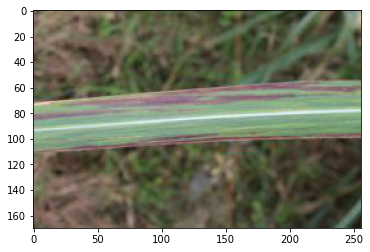

Bacterial Blight = 89.09025461395139%
Red Rot = 8.278888417227192%
Healthy = 2.630856968821408%
The predicted image is : Bacterial Blight


In [106]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Bacterial Blight/S_BLB (5).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=model.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model.predict(l)[0]])

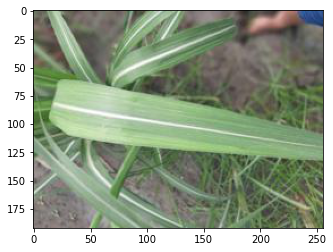

Bacterial Blight = 3.031905027060943%
Red Rot = 7.820879986286873%
Healthy = 89.14721498665217%
The predicted image is : Healthy


In [107]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Healthy/S_H (5).jpg"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=model.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model.predict(l)[0]])

### 70:30

In [114]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,
                                               random_state=77,
                                               stratify=y)

In [115]:
# Defining the parameters grid for GridSearchCV
param_grid={'C':[0.1,1,10,100],
            'gamma':[0.0001,0.001,0.1,1],
            'kernel':['rbf','poly']}
  
# Creating a support vector classifier
svc=svm.SVC(probability=True)
  
# Creating a model using GridSearchCV with the parameters grid
model=GridSearchCV(svc,param_grid)

In [116]:
# Training the model using the training data
model.fit(x_train,y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [117]:
# Testing the model using the testing data
y_pred = model.predict(x_test)
  
# Calculating the accuracy of the model
accuracy = accuracy_score(y_pred, y_test)
  
# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")

The model is 74.44444444444444% accurate


In [118]:
print(classification_report(y_test, y_pred, target_names=['Bacterial Blight', 'Red Rot','Healthy']))

                  precision    recall  f1-score   support

Bacterial Blight       0.69      0.83      0.76        30
         Red Rot       0.70      0.47      0.56        30
         Healthy       0.82      0.93      0.87        30

        accuracy                           0.74        90
       macro avg       0.74      0.74      0.73        90
    weighted avg       0.74      0.74      0.73        90



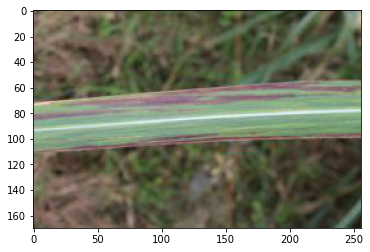

Bacterial Blight = 90.83356247885345%
Red Rot = 7.164839433958452%
Healthy = 2.0015980871881225%
The predicted image is : Bacterial Blight


In [119]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Bacterial Blight/S_BLB (5).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=model.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model.predict(l)[0]])

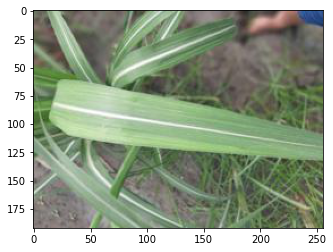

Bacterial Blight = 2.0325375660322336%
Red Rot = 5.426275661047146%
Healthy = 92.54118677292061%
The predicted image is : Healthy


In [120]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Healthy/S_H (5).jpg"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=model.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model.predict(l)[0]])

### 60:40

In [121]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.40,
                                               random_state=77,
                                               stratify=y)

In [122]:
# Defining the parameters grid for GridSearchCV
param_grid={'C':[0.1,1,10,100],
            'gamma':[0.0001,0.001,0.1,1],
            'kernel':['rbf','poly']}
  
# Creating a support vector classifier
svc=svm.SVC(probability=True)
  
# Creating a model using GridSearchCV with the parameters grid
model=GridSearchCV(svc,param_grid)

In [ ]:
# Training the model using the training data
model.fit(x_train,y_train)

In [ ]:
# Testing the model using the testing data
y_pred = model.predict(x_test)
  
# Calculating the accuracy of the model
accuracy = accuracy_score(y_pred, y_test)
  
# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Bacterial Blight', 'Red Rot','Healthy']))

In [ ]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Bacterial Blight/S_BLB (5).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=model.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model.predict(l)[0]])

In [ ]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Healthy/S_H (5).jpg"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=model.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model.predict(l)[0]])

### Random Forest

In [147]:
from sklearn.metrics import accuracy_score
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [148]:
Categories=['Bacterial Blight','Red Rot','Healthy']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir= "C:/Users/meghn/Internship/Sugarcane/sugarcane RA"
#path which contains all the categories of images
for i in Categories:
      
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(150,150,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)

loading... category : Bacterial Blight
loaded category:Bacterial Blight successfully
loading... category : Red Rot
loaded category:Red Rot successfully
loading... category : Healthy
loaded category:Healthy successfully


In [149]:
#dataframe
df=pd.DataFrame(flat_data) 
df['Target']=target
df.shape

(300, 67501)

In [150]:
#input data 
x=df.iloc[:,:-1] 
#output data
y=df.iloc[:,-1]

#### 80:20

In [151]:
# Splitting the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,
                                               random_state=77,
                                               stratify=y)

In [152]:
# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train.values.reshape(len(x_train), -1), y_train)


RandomForestClassifier(random_state=42)

In [153]:
# Predict on test set
y_pred = clf.predict(x_test.values.reshape(len(x_test), -1))

In [154]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 68.33%


In [155]:
print(classification_report(y_test, y_pred, target_names=['Bacterial Blight', 'Red Rot','Healthy']))

                  precision    recall  f1-score   support

Bacterial Blight       0.62      0.65      0.63        20
         Red Rot       0.64      0.45      0.53        20
         Healthy       0.76      0.95      0.84        20

        accuracy                           0.68        60
       macro avg       0.67      0.68      0.67        60
    weighted avg       0.67      0.68      0.67        60



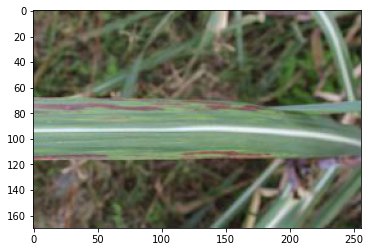

Bacterial Blight = 80.0%
Red Rot = 14.000000000000002%
Healthy = 6.0%
The predicted image is : Bacterial Blight


In [156]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Bacterial Blight/S_BLB (7).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

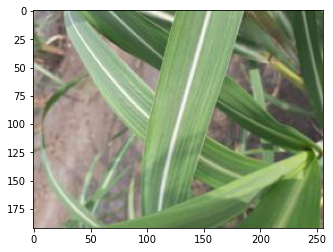

Bacterial Blight = 9.0%
Red Rot = 14.000000000000002%
Healthy = 77.0%
The predicted image is : Healthy


In [157]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Healthy/S_H (1).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

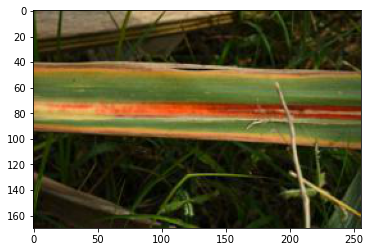

Bacterial Blight = 18.0%
Red Rot = 72.0%
Healthy = 10.0%
The predicted image is : Red Rot


In [158]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Red Rot/S_RR (9).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

#### 70:30

In [159]:
# Splitting the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,
                                               random_state=77,
                                               stratify=y)

In [160]:
# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train.values.reshape(len(x_train), -1), y_train)


RandomForestClassifier(random_state=42)

In [161]:
# Predict on test set
y_pred = clf.predict(x_test.values.reshape(len(x_test), -1))

In [162]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 73.33%


In [163]:
print(classification_report(y_test, y_pred, target_names=['Bacterial Blight', 'Red Rot','Healthy']))

                  precision    recall  f1-score   support

Bacterial Blight       0.71      0.73      0.72        30
         Red Rot       0.71      0.50      0.59        30
         Healthy       0.76      0.97      0.85        30

        accuracy                           0.73        90
       macro avg       0.73      0.73      0.72        90
    weighted avg       0.73      0.73      0.72        90



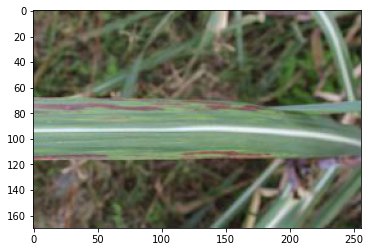

Bacterial Blight = 74.0%
Red Rot = 16.0%
Healthy = 10.0%
The predicted image is : Bacterial Blight


In [164]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Bacterial Blight/S_BLB (7).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

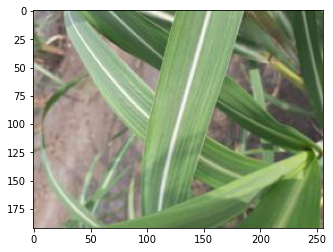

Bacterial Blight = 6.0%
Red Rot = 10.0%
Healthy = 84.0%
The predicted image is : Healthy


In [165]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Healthy/S_H (1).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

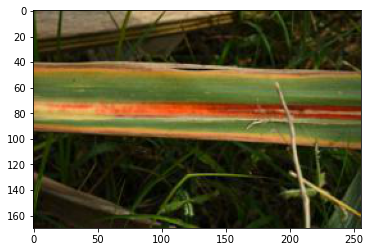

Bacterial Blight = 23.0%
Red Rot = 66.0%
Healthy = 11.0%
The predicted image is : Red Rot


In [166]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Red Rot/S_RR (9).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

#### 60:40

In [167]:
# Splitting the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.40,
                                               random_state=77,
                                               stratify=y)

In [168]:
# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train.values.reshape(len(x_train), -1), y_train)



RandomForestClassifier(random_state=42)

In [169]:
# Predict on test set
y_pred = clf.predict(x_test.values.reshape(len(x_test), -1))



In [170]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 71.67%


In [171]:
print(classification_report(y_test, y_pred, target_names=['Bacterial Blight', 'Red Rot','Healthy']))

                  precision    recall  f1-score   support

Bacterial Blight       0.68      0.75      0.71        40
         Red Rot       0.65      0.42      0.52        40
         Healthy       0.78      0.97      0.87        40

        accuracy                           0.72       120
       macro avg       0.71      0.72      0.70       120
    weighted avg       0.71      0.72      0.70       120



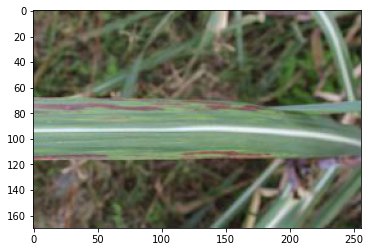

Bacterial Blight = 76.0%
Red Rot = 17.0%
Healthy = 7.000000000000001%
The predicted image is : Bacterial Blight


In [172]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Bacterial Blight/S_BLB (7).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

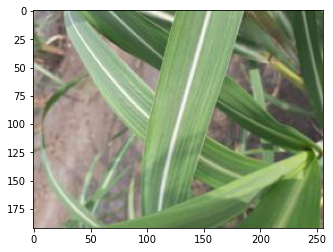

Bacterial Blight = 6.0%
Red Rot = 7.000000000000001%
Healthy = 87.0%
The predicted image is : Healthy


In [173]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Healthy/S_H (1).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

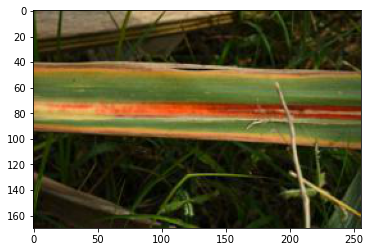

Bacterial Blight = 21.0%
Red Rot = 62.0%
Healthy = 17.0%
The predicted image is : Red Rot


In [174]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Red Rot/S_RR (9).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

### KNN

In [175]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [176]:
Categories=['Bacterial Blight','Red Rot','Healthy']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir= "C:/Users/meghn/Internship/Sugarcane/sugarcane RA"
#path which contains all the categories of images
for i in Categories:
      
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(150,150,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)

loading... category : Bacterial Blight
loaded category:Bacterial Blight successfully
loading... category : Red Rot
loaded category:Red Rot successfully
loading... category : Healthy
loaded category:Healthy successfully


In [177]:
#dataframe
df=pd.DataFrame(flat_data) 
df['Target']=target
df.shape

(300, 67501)

In [178]:
#input data 
x=df.iloc[:,:-1] 
#output data
y=df.iloc[:,-1]

#### 80:20

In [179]:
# Splitting the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,
                                               random_state=77,
                                               stratify=y)

In [180]:
# Train KNN classifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(x_train.values.reshape(len(x_train), -1), y_train)




KNeighborsClassifier()

In [181]:
# Predict on test set
y_pred = clf.predict(x_test.values.reshape(len(x_test), -1))



In [182]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 65.00%


In [183]:
print(classification_report(y_test, y_pred, target_names=['Bacterial Blight', 'Red Rot','Healthy']))

                  precision    recall  f1-score   support

Bacterial Blight       0.60      0.75      0.67        20
         Red Rot       1.00      0.20      0.33        20
         Healthy       0.65      1.00      0.78        20

        accuracy                           0.65        60
       macro avg       0.75      0.65      0.59        60
    weighted avg       0.75      0.65      0.59        60



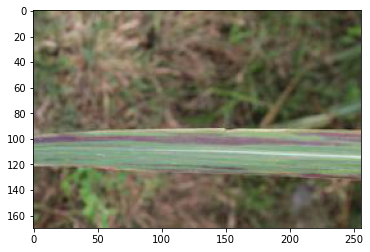

Bacterial Blight = 80.0%
Red Rot = 0.0%
Healthy = 20.0%
The predicted image is : Bacterial Blight


In [184]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Bacterial Blight/S_BLB (6).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

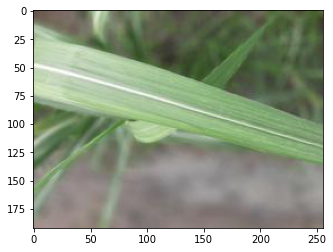

Bacterial Blight = 0.0%
Red Rot = 0.0%
Healthy = 100.0%
The predicted image is : Healthy


In [185]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Healthy/S_H (6).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

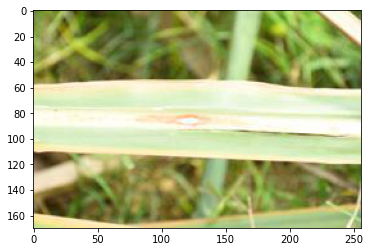

Bacterial Blight = 0.0%
Red Rot = 60.0%
Healthy = 40.0%
The predicted image is : Red Rot


In [186]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Red Rot/S_RR (8).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

#### 70:30

In [187]:
# Splitting the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,
                                               random_state=77,
                                               stratify=y)

In [188]:
# Train KNN classifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(x_train.values.reshape(len(x_train), -1), y_train)

KNeighborsClassifier()

In [189]:
# Predict on test set
y_pred = clf.predict(x_test.values.reshape(len(x_test), -1))

In [190]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 65.56%


In [191]:
print(classification_report(y_test, y_pred, target_names=['Bacterial Blight', 'Red Rot','Healthy']))

                  precision    recall  f1-score   support

Bacterial Blight       0.65      0.73      0.69        30
         Red Rot       1.00      0.23      0.38        30
         Healthy       0.61      1.00      0.76        30

        accuracy                           0.66        90
       macro avg       0.75      0.66      0.61        90
    weighted avg       0.75      0.66      0.61        90



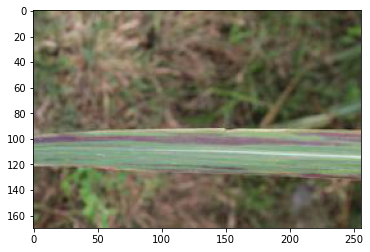

Bacterial Blight = 60.0%
Red Rot = 20.0%
Healthy = 20.0%
The predicted image is : Bacterial Blight


In [192]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Bacterial Blight/S_BLB (6).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

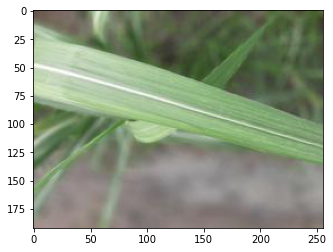

Bacterial Blight = 0.0%
Red Rot = 0.0%
Healthy = 100.0%
The predicted image is : Healthy


In [193]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Healthy/S_H (6).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

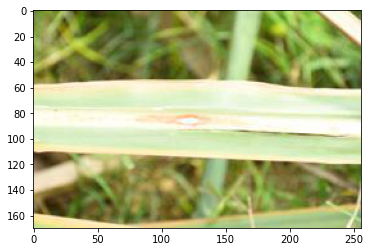

Bacterial Blight = 0.0%
Red Rot = 60.0%
Healthy = 40.0%
The predicted image is : Red Rot


In [194]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Red Rot/S_RR (8).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

#### 60:40

In [195]:
# Splitting the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.40,
                                               random_state=77,
                                               stratify=y)

In [196]:
# Train KNN classifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(x_train.values.reshape(len(x_train), -1), y_train)

KNeighborsClassifier()

In [197]:
# Predict on test set
y_pred = clf.predict(x_test.values.reshape(len(x_test), -1))

In [198]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 65.83%


In [199]:
print(classification_report(y_test, y_pred, target_names=['Bacterial Blight', 'Red Rot','Healthy']))

                  precision    recall  f1-score   support

Bacterial Blight       0.71      0.75      0.73        40
         Red Rot       0.90      0.23      0.36        40
         Healthy       0.59      1.00      0.74        40

        accuracy                           0.66       120
       macro avg       0.73      0.66      0.61       120
    weighted avg       0.73      0.66      0.61       120



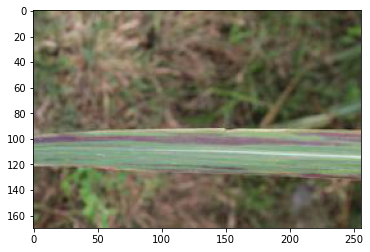

Bacterial Blight = 60.0%
Red Rot = 20.0%
Healthy = 20.0%
The predicted image is : Bacterial Blight


In [200]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Bacterial Blight/S_BLB (6).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

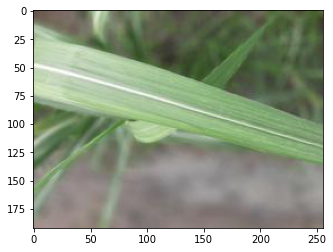

Bacterial Blight = 0.0%
Red Rot = 0.0%
Healthy = 100.0%
The predicted image is : Healthy


In [201]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Healthy/S_H (6).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])

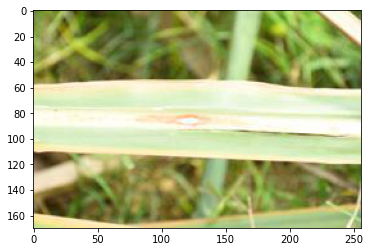

Bacterial Blight = 0.0%
Red Rot = 40.0%
Healthy = 60.0%
The predicted image is : Healthy


In [202]:
path="C:/Users/meghn/Internship/Sugarcane/sugarcane RA/Red Rot/S_RR (8).JPG"
img=imread(path)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=clf.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[clf.predict(l)[0]])